In [2]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

### Definition of input folder

In [3]:
folder_path = "../study"
stats_path = folder_path + "/stats"

### Concatenation of all patient's metrics

In [4]:
## Read the list of subjects and for each subject do the tractography
dest_success = folder_path + "/subjects/subj_list.json"
with open(dest_success, 'r') as file:
    patient_list = json.load(file)
del file

dfs = []
for p_code in patient_list:
    metric_folder = "%s/subjects/%s/dMRI/microstructure/%s_metrics.csv" % (folder_path, p_code, p_code)
    if not os.path.exists(metric_folder):
        print(metric_folder, "doesn't exists")
        continue
    dfs.append(pd.read_csv(metric_folder))
    del metric_folder
del p_code

df = pd.concat(dfs, ignore_index=True)
del dfs

"""
Check that there are the expected number of columns:
23 metrics, 4 measure for each metric, 5 tracts, 4 roi, 2 means right and left
For each tract we measure the number of tracts found
The ID
"""
assert df.columns.size == 23 * 4 * (5+6) * 2 + (5*2) + 1 # 1656

info_df = pd.read_csv(stats_path + "/info.csv")
non_dMRIfeatures = info_df.columns.drop(["ID"])

df = pd.merge(info_df, df, on="ID")
del info_df

if not os.path.isdir(stats_path):
    os.mkdir(stats_path)

df.to_csv("%s/dataset.csv" % stats_path, index=False)

# Exploration

# Features names:
```json
metrics = {
    "dti" : ["FA", "AD", "RD", "MD"],
    "noddi" : ["icvf", "odi", "fbundle", "fextra", "fintra", "fiso" ],
    "diamond" : ["wFA", "wMD", "wAxD", "wRD", "frac_c0", "frac_c1", "frac_csf_d"],
    "mf" : ["fvf_f0", "fvf_f1", "fvf_tot", "frac_f0", "frac_f1", "frac_csf_mf"]
}

masks_name = [
    "thalamus",
    "hippocampus",
    "amygdala",
    "accumbens",
    "putamen",
    "pallidum",

    "fornix",
    "inf-longi-fasci",
    "sup-longi-fasci",
    "thalamus-AntCingCtx",
    "thalamus-Insula",
]
```

They are composed in the following manner:

[right|left]-[mask_name]\_[metrics]\_[mean|std|skew|kurt]

Here the explanation of some features:

NR-RP/R:

- NR-RP/R == 0 => Non Responder
- NR-RP/R == 1 => Partial responder or Responder

NR-RP-R:

- NR-RP-R == 0 => Non Responder
- NR-RP-R == 1 => Partial Responder
- NR-RP-R == 2 => Responder

epilepsy_type:

- epilepsy_type == 1 => Generalized
- epilepsy_type == 2 => Focal

In [211]:
# Reading the whole dataset
df = pd.read_csv("%s/dataset.csv" % stats_path, index_col="ID")
col_nTract = df.filter(regex=r'nTracts').columns
col_dMRI = df.filter(regex=r'mean|std|skew|kurt').columns
col_cont = ["age", "therapy_duration", "epilepsy_onset_age", "epilepsy_duration", *col_nTract, *col_dMRI]

In [8]:
print(df.value_counts("resp"))
print(df.value_counts("respPart"))

resp
1    12
0     7
Name: count, dtype: int64
respPart
2    8
0    7
1    4
Name: count, dtype: int64


In our case we have few examples (patients), and so the model will not be so accurate. Then the difference between patients responders and not is different, so our model will be bias influenced.

While if we see the number of samples between responders, partial and not, the number of samples for each class is almost equilibrate.

icsf is the thresholded f_intra, so we expect some correlation between the two metrics

<Axes: >

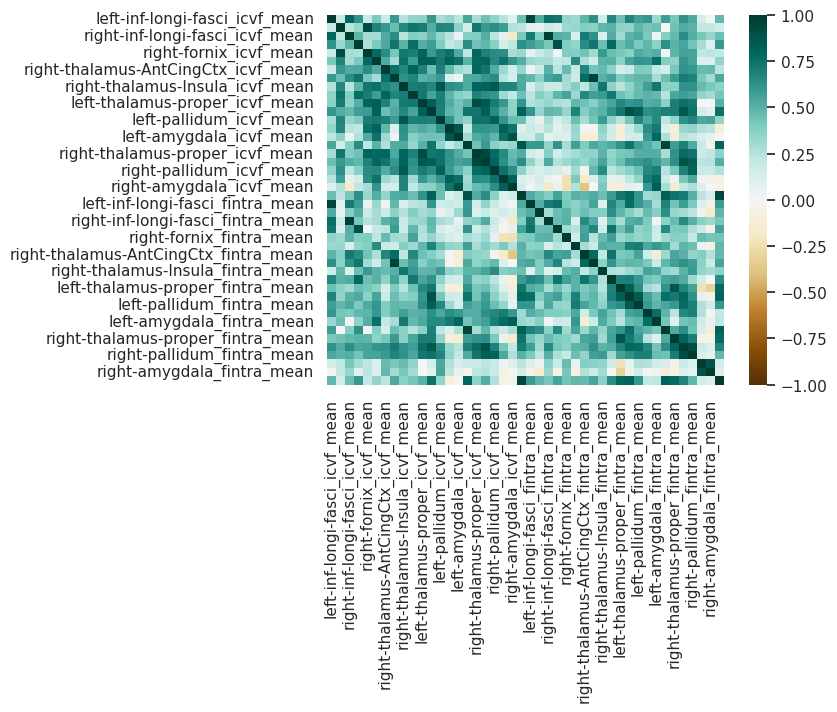

In [25]:
sns.heatmap(df.filter(regex=r'fintra_mean|icvf_mean').corr("pearson"), vmin=-1, vmax=1, cmap="BrBG")

resp                                 1.000000
respPart                             0.906419
right-inf-longi-fasci_nTracts        0.412263
epilepsy_type                        0.330719
epilepsy_onset_age                   0.312888
right-thalamus-AntCingCtx_nTracts    0.301605
left-sup-longi-fasci_nTracts         0.239593
therapy_duration                     0.211080
right-fornix_nTracts                 0.210120
AEDs                                 0.209822
right-sup-longi-fasci_nTracts        0.170105
epilepsy_duration                    0.155117
sex                                  0.149514
left-thalamus-AntCingCtx_nTracts     0.147136
age                                  0.141750
left-fornix_nTracts                  0.140507
left-inf-longi-fasci_nTracts         0.123848
benzo                                0.093560
left-thalamus-Insula_nTracts         0.060211
right-thalamus-Insula_nTracts        0.004052
Name: resp, dtype: float64


<Axes: >

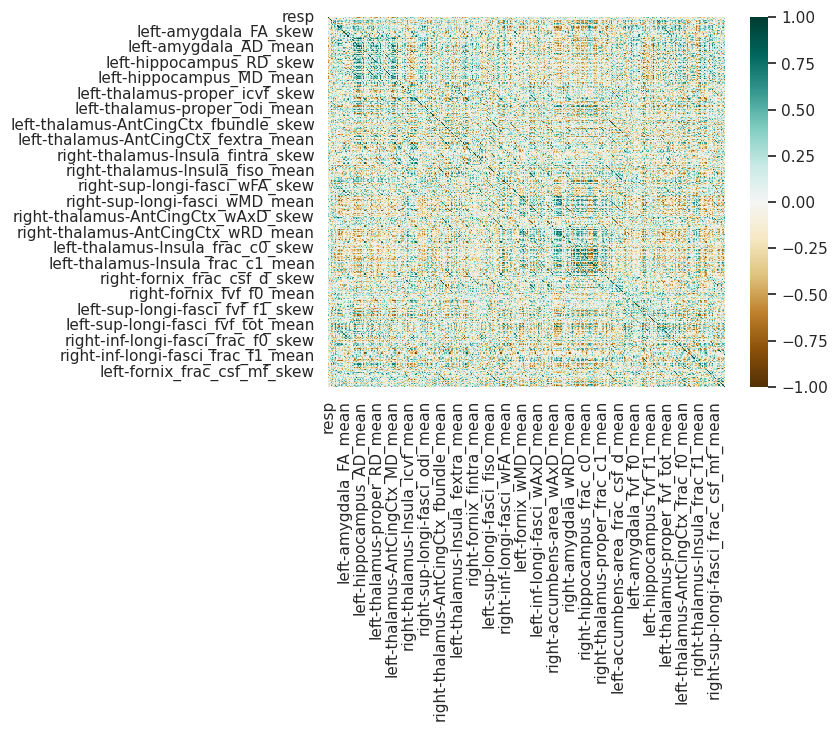

In [97]:
print(abs(df[[*non_dMRIfeatures,*col_nTract]].corr("pearson")["resp"]).sort_values(ascending=False))
sns.heatmap(df.corr("pearson"), vmin=-1, vmax=1, cmap="BrBG")

<Axes: xlabel='resp', ylabel='right-fornix_RD_mean'>

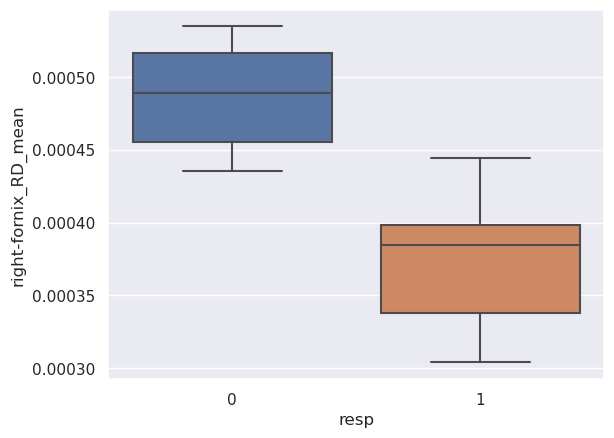

In [234]:
sns.boxplot(df, y="right-fornix_RD_mean", x="resp")

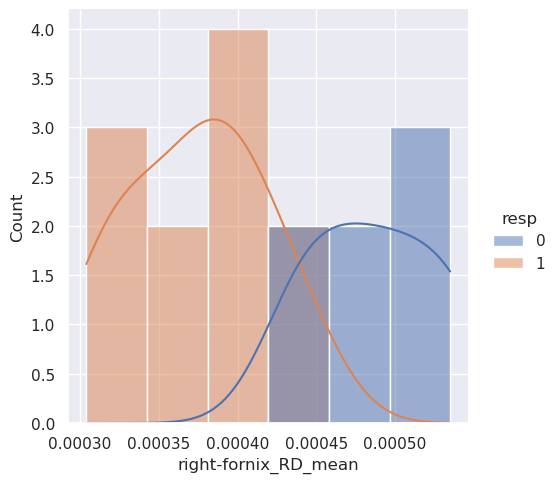

In [235]:
sns.displot(df, x="right-fornix_RD_mean", hue="resp", kde=True)

<Axes: xlabel='left-fornix_AD_std', ylabel='left-fornix_RD_mean'>

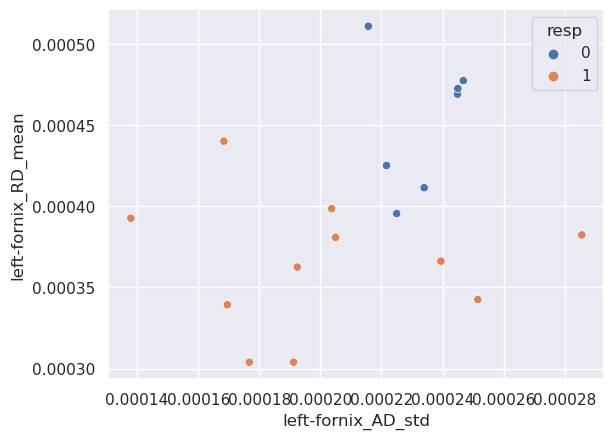

In [27]:
sns.scatterplot(df, x="left-fornix_AD_std", y="left-fornix_RD_mean", hue="resp")

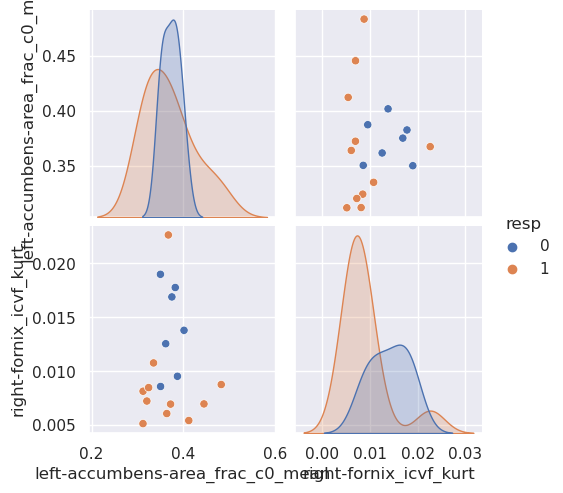

In [239]:
toPlot = ['left-accumbens-area_frac_c0_mean', 'right-fornix_icvf_kurt']
sns.pairplot(df, hue="resp", x_vars=toPlot, y_vars=toPlot)

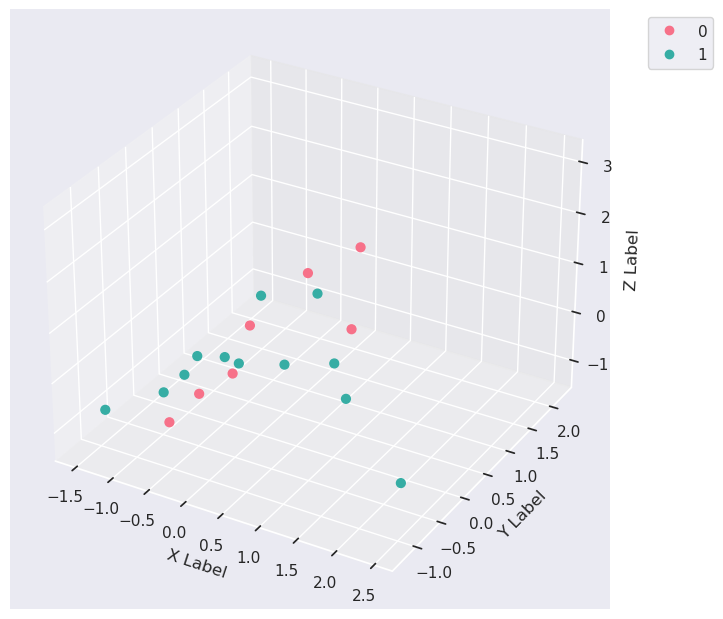

In [316]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

a = df
features = ['left-inf-longi-fasci_nTracts', 'left-thalamus-Insula_nTracts', 'right-inf-longi-fasci_nTracts']
x = a[features[0]]
y = a[features[1]]
z = a[features[2]]
labs = a["resp"]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 2).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=labs, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# Divide features from labels

In [104]:
y = df["resp"]
X = df.drop(["resp", "respPart"], axis=1) 

# Remove features too small to avoid underflow

In [242]:
tooSmall = df.columns[df.abs().min() < 1e-12]
col_contCorr = list(set(col_cont) - set(tooSmall))

tooSmall

Index(['resp', 'respPart', 'benzo', 'epilepsy_onset_age',
       'left-fornix_nTracts', 'right-fornix_nTracts',
       'right-thalamus-AntCingCtx_nTracts', 'left-thalamus-AntCingCtx_nTracts',
       'left-inf-longi-fasci_AD_skew', 'left-inf-longi-fasci_AD_kurt',
       ...
       'right-thalamus-proper_wRD_skew', 'right-thalamus-proper_wRD_kurt',
       'right-putamen_wRD_skew', 'right-putamen_wRD_kurt',
       'right-pallidum_wRD_skew', 'right-pallidum_wRD_kurt',
       'right-hippocampus_wRD_kurt', 'right-amygdala_wRD_kurt',
       'right-accumbens-area_wRD_skew', 'right-accumbens-area_wRD_kurt'],
      dtype='object', length=234)

# Small variance feature filtering

In [214]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

X = df[col_contCorr]
y = df["resp"]

robScal = RobustScaler()
varThres = VarianceThreshold(0.5)

pipe = Pipeline([
    ("RobustScaler", robScal),
    ("VarThres", varThres)
])

pipe.fit(X)
df_cutVar = pd.DataFrame(pipe.transform(X), index=df.index, columns=X.columns[varThres.get_support()])

df_cutVar

,left-thalamus-proper_frac_csf_d_skew,left-inf-longi-fasci_MD_std,left-sup-longi-fasci_odi_kurt,left-hippocampus_icvf_skew,right-accumbens-area_wFA_std,right-fornix_frac_c1_mean,left-hippocampus_FA_mean,left-inf-longi-fasci_fintra_kurt,right-sup-longi-fasci_wMD_mean,right-thalamus-Insula_fvf_tot_mean,...,left-inf-longi-fasci_frac_c1_std,right-thalamus-AntCingCtx_icvf_kurt,right-inf-longi-fasci_fextra_skew,right-thalamus-proper_fbundle_mean,right-inf-longi-fasci_fintra_kurt,left-inf-longi-fasci_frac_f0_skew,left-accumbens-area_fintra_std,right-putamen_fvf_tot_skew,right-sup-longi-fasci_fintra_std,right-thalamus-AntCingCtx_frac_c1_kurt
ID,,,,,,,,,,,,,,,,,,,,,
VNSLC_01,0.680678,1.478634,-0.771411,0.527548,0.512181,-0.414319,-0.435364,-0.050661,0.000000,0.199677,...,0.462276,1.827719,-5.408776,-2.464864,-0.536451,-0.170469,0.252608,0.624471,-0.356336,0.883908
VNSLC_02,-0.794739,0.090458,-0.518764,-1.533665,3.187140,0.510133,-0.628311,0.734027,-0.792284,1.461317,...,-0.042277,-0.954769,0.890231,1.343698,1.034654,-0.504290,1.024056,1.291503,-0.524919,-0.332863
VNSLC_03,1.185140,0.044508,-1.701624,-2.341142,-2.099286,NaN,2.773263,1.050925,1.297645,0.348108,...,-0.439466,0.572763,-0.022692,-3.529232,-0.122032,0.935822,0.712778,0.891874,0.020861,-0.037401
VNSLC_04,-0.711580,-1.211904,-0.944256,-0.959985,0.105046,1.673093,0.270893,-0.558910,0.386250,-1.334142,...,0.822778,1.218815,-1.292549,0.316270,0.318326,-0.342888,-0.675865,-0.440694,-0.372466,0.318851
VNSLC_06,1.104906,0.134869,-0.658063,-0.486141,-0.415187,-0.518648,-0.480054,0.199002,-0.103949,-0.316824,...,-0.416601,-0.721212,-0.596694,0.467346,0.079215,-0.334068,-0.503281,-0.015841,-0.976820,-1.409527
VNSLC_07,-0.510060,-0.515495,-0.270971,-0.337658,0.641552,0.109518,0.468531,-0.147166,-0.610677,0.058276,...,-0.020841,-1.031655,-0.171247,0.920784,-0.083249,0.089823,-0.791630,0.267339,-0.648914,-0.734052
VNSLC_09,0.155130,2.531418,-0.412742,0.081589,1.941306,0.499339,0.578061,4.245715,-1.738163,1.694981,...,-0.352094,-0.064226,2.445544,0.161431,3.606036,0.070922,1.077454,0.036831,0.561079,-0.537948
VNSLC_10,0.592044,-1.348624,0.000000,0.367129,-0.149214,-0.594301,0.792917,-0.360373,0.268729,-0.340980,...,0.497186,0.727300,0.009492,0.000000,-0.979962,-0.178687,-0.183392,-0.390618,-0.324278,0.037401
VNSLC_11,-0.006191,-0.237948,2.627283,-0.627491,-0.355834,-0.839714,0.000000,2.074739,-0.042448,-0.593960,...,0.009123,0.978251,-1.164363,0.503769,0.000000,1.340724,0.000000,0.635378,-0.194534,0.316065


# Managing of NaN values

There are different method to handle the missing values:
- Deleting the rows
- Imputing the missing values with the mean/median
- Predicting the missing values (Machine Learning with sklearn) https://scikit-learn.org/stable/modules/impute.html

For the ROI taken from tracts we will use a prediction method to impute the NaN values

In [215]:
(df[col_nTract] == 0).sum(axis=1)
(df[col_nTract] == 0).sum(axis=0)
df[col_nTract].loc[(df[col_nTract] == 0).sum(axis=1) > 0, (df[col_nTract] == 0).sum(axis=0) > 0]


,left-fornix_nTracts,right-fornix_nTracts,right-thalamus-AntCingCtx_nTracts,left-thalamus-AntCingCtx_nTracts
ID,,,,
VNSLC_03,0,0,233,0
VNSLC_04,2,4655,93,0
VNSLC_17,67,1,0,90


#### Mean imputation

Show the means, to understand if the probabilistic imputation is better than the mean/median.

In [216]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

imp = SimpleImputer(missing_values=np.nan, strategy="mean")

pre_pipe = Pipeline([
    #("scaling", StandardScaler()),
    ("imputing", imp),
])

df_mean = pd.DataFrame(pre_pipe.fit_transform(df_cutVar))
df_mean.columns = df_cutVar.columns
df_mean.index = df_cutVar.index

df_mean

,left-thalamus-proper_frac_csf_d_skew,left-inf-longi-fasci_MD_std,left-sup-longi-fasci_odi_kurt,left-hippocampus_icvf_skew,right-accumbens-area_wFA_std,right-fornix_frac_c1_mean,left-hippocampus_FA_mean,left-inf-longi-fasci_fintra_kurt,right-sup-longi-fasci_wMD_mean,right-thalamus-Insula_fvf_tot_mean,...,left-inf-longi-fasci_frac_c1_std,right-thalamus-AntCingCtx_icvf_kurt,right-inf-longi-fasci_fextra_skew,right-thalamus-proper_fbundle_mean,right-inf-longi-fasci_fintra_kurt,left-inf-longi-fasci_frac_f0_skew,left-accumbens-area_fintra_std,right-putamen_fvf_tot_skew,right-sup-longi-fasci_fintra_std,right-thalamus-AntCingCtx_frac_c1_kurt
ID,,,,,,,,,,,,,,,,,,,,,
VNSLC_01,0.680678,1.478634,-0.771411,0.527548,0.512181,-0.414319,-0.435364,-0.050661,0.000000,0.199677,...,0.462276,1.827719,-5.408776,-2.464864,-0.536451,-0.170469,0.252608,0.624471,-0.356336,0.883908
VNSLC_02,-0.794739,0.090458,-0.518764,-1.533665,3.187140,0.510133,-0.628311,0.734027,-0.792284,1.461317,...,-0.042277,-0.954769,0.890231,1.343698,1.034654,-0.504290,1.024056,1.291503,-0.524919,-0.332863
VNSLC_03,1.185140,0.044508,-1.701624,-2.341142,-2.099286,-0.034916,2.773263,1.050925,1.297645,0.348108,...,-0.439466,0.572763,-0.022692,-3.529232,-0.122032,0.935822,0.712778,0.891874,0.020861,-0.037401
VNSLC_04,-0.711580,-1.211904,-0.944256,-0.959985,0.105046,1.673093,0.270893,-0.558910,0.386250,-1.334142,...,0.822778,1.218815,-1.292549,0.316270,0.318326,-0.342888,-0.675865,-0.440694,-0.372466,0.318851
VNSLC_06,1.104906,0.134869,-0.658063,-0.486141,-0.415187,-0.518648,-0.480054,0.199002,-0.103949,-0.316824,...,-0.416601,-0.721212,-0.596694,0.467346,0.079215,-0.334068,-0.503281,-0.015841,-0.976820,-1.409527
VNSLC_07,-0.510060,-0.515495,-0.270971,-0.337658,0.641552,0.109518,0.468531,-0.147166,-0.610677,0.058276,...,-0.020841,-1.031655,-0.171247,0.920784,-0.083249,0.089823,-0.791630,0.267339,-0.648914,-0.734052
VNSLC_09,0.155130,2.531418,-0.412742,0.081589,1.941306,0.499339,0.578061,4.245715,-1.738163,1.694981,...,-0.352094,-0.064226,2.445544,0.161431,3.606036,0.070922,1.077454,0.036831,0.561079,-0.537948
VNSLC_10,0.592044,-1.348624,0.000000,0.367129,-0.149214,-0.594301,0.792917,-0.360373,0.268729,-0.340980,...,0.497186,0.727300,0.009492,0.000000,-0.979962,-0.178687,-0.183392,-0.390618,-0.324278,0.037401
VNSLC_11,-0.006191,-0.237948,2.627283,-0.627491,-0.355834,-0.839714,0.000000,2.074739,-0.042448,-0.593960,...,0.009123,0.978251,-1.164363,0.503769,0.000000,1.340724,0.000000,0.635378,-0.194534,0.316065


#### Probabilistic imputation

In [217]:
from sklearn.experimental import enable_iterative_imputer # useful to enable the experimental IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(
    n_estimators=100,
    criterion="squared_error",
    max_depth=10,
    max_features="sqrt",
    bootstrap=True,
    max_samples=0.5,
    n_jobs=-1,
)
imp = IterativeImputer(
    estimator=forest, 
    max_iter=10, 
    missing_values=np.nan,
    initial_strategy="mean",
    n_nearest_features=10, # the number of ROI
    add_indicator=False, # We don't need to add_indicator, because the number of tracts have this information
    verbose=2,
    )

pre_pipe = Pipeline([
    #("scaling", StandardScaler()),
    ("imputing", imp),
])


df_prob = pd.DataFrame(pre_pipe.fit_transform(df_cutVar))
df_prob.columns = df_cutVar.columns
df_prob.index = df_cutVar.index

df_prob

[IterativeImputer] Completing matrix with shape (19, 1394)
[IterativeImputer] Ending imputation round 1/10, elapsed time 241.71
[IterativeImputer] Change: 42.61972402748523, scaled tolerance: 0.11071291448614627 
[IterativeImputer] Ending imputation round 2/10, elapsed time 483.30
[IterativeImputer] Change: 47.520939229923485, scaled tolerance: 0.11071291448614627 
[IterativeImputer] Ending imputation round 3/10, elapsed time 723.96
[IterativeImputer] Change: 44.45599945537903, scaled tolerance: 0.11071291448614627 
[IterativeImputer] Ending imputation round 4/10, elapsed time 968.20
[IterativeImputer] Change: 47.97468625836504, scaled tolerance: 0.11071291448614627 
[IterativeImputer] Ending imputation round 5/10, elapsed time 1220.24
[IterativeImputer] Change: 50.77678322080067, scaled tolerance: 0.11071291448614627 
[IterativeImputer] Ending imputation round 6/10, elapsed time 1462.59
[IterativeImputer] Change: 49.06790317333783, scaled tolerance: 0.11071291448614627 
[IterativeImpu

/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Analysis over the number of streamline for tract

We have generated 2M of seed to generate the streamlines for each ROI tract. So, there are some patients have 4k streamlines for the fornix and some that have 0 streamlines.

This is a value that depends on the physical structure of the tract in the patient. A small value means a damaged or missing structure, because wan't found any streamline that compose the ROI.

# Feature Selection

## Filter Approach (Univariate)

The methods based on **F-test** estimate the degree of **linear dependency** between two random variables. On the other hand, **mutual information** methods can capture any kind of statistical dependency, but being nonparametric, they **require more samples** for accurate estimation.

### ANOVA F-value 

In [230]:
from sklearn.feature_selection import SelectKBest, f_classif

X = df_prob
y = df["resp"]

sel = SelectKBest(f_classif, k=10).fit(X,y)
scores = sel.scores_
scores /= scores.max()
scores = pd.DataFrame(scores, index=X.columns, columns=["score"]).sort_values("score", ascending=False)
print(scores[:10])
# print(sel.transform(X))
# X.filter(regex=r'fornix_RD_mean')

X.columns[sel.get_support()]

                                        score
right-fornix_RD_mean                 1.000000
left-fornix_RD_mean                  0.591145
left-fornix_MD_mean                  0.535006
right-inf-longi-fasci_odi_skew       0.497869
left-thalamus-AntCingCtx_fvf_f1_std  0.466920
right-fornix_icvf_mean               0.410724
left-putamen_frac_csf_mf_std         0.404626
right-fornix_fvf_tot_mean            0.386107
right-thalamus-Insula_AD_mean        0.369660
left-accumbens-area_fvf_f1_std       0.363954


Index(['right-fornix_fvf_tot_mean', 'left-thalamus-AntCingCtx_fvf_f1_std',
       'left-fornix_RD_mean', 'right-inf-longi-fasci_odi_skew',
       'right-fornix_RD_mean', 'left-accumbens-area_fvf_f1_std',
       'right-thalamus-Insula_AD_mean', 'left-fornix_MD_mean',
       'right-fornix_icvf_mean', 'left-putamen_frac_csf_mf_std'],
      dtype='object')

### Mutual Information

In [233]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

X = df_prob
y = df["resp"]

sel = SelectKBest(mutual_info_classif, k=10).fit(X, y)
scores = sel.scores_
scores /= scores.max()
scores = pd.DataFrame(scores, index=X.columns, columns=["score"]).sort_values("score", ascending=False)
print(scores[:10])
# print(sel.transform(X))
# X.filter(regex=r'fornix_RD_mean')

X.columns[sel.get_support()]

                                   score
right-fornix_RD_mean            1.000000
left-accumbens-area_MD_std      0.929573
left-putamen_frac_csf_mf_std    0.924830
left-thalamus-Insula_RD_std     0.918960
right-inf-longi-fasci_wFA_kurt  0.833180
right-inf-longi-fasci_odi_kurt  0.806727
right-fornix_icvf_mean          0.753495
left-fornix_frac_csf_mf_std     0.696023
left-hippocampus_RD_mean        0.693630
right-pallidum_fbundle_std      0.680853


Index(['left-accumbens-area_MD_std', 'left-hippocampus_RD_mean',
       'right-inf-longi-fasci_wFA_kurt', 'left-fornix_frac_csf_mf_std',
       'right-fornix_RD_mean', 'left-thalamus-Insula_RD_std',
       'right-fornix_icvf_mean', 'right-inf-longi-fasci_odi_kurt',
       'left-putamen_frac_csf_mf_std', 'right-pallidum_fbundle_std'],
      dtype='object')

### Fisher Score (chi-square) 

**Only for categorical data** and **non negative**

In [236]:
from sklearn.feature_selection import SelectKBest, chi2

X = df_prob
y = df["resp"]

sel = SelectKBest(chi2, k=10).fit(X, y)
scores = sel.scores_
scores /= scores.max()
scores = pd.DataFrame(scores, index=X.columns, columns=["score"]).sort_values("score", ascending=False)
print(scores[:10])
# print(sel.transform(X))
# X.filter(regex=r'fornix_RD_mean')

X.columns[sel.get_support()]

ValueError: Input X must be non-negative.

## Wrapper methods

In [62]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=7, shuffle=True)

### Forward

In [238]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import svm

X = df_prob
y = df["resp"]

clf_lin = svm.LinearSVC(
    C=1e-1,
    class_weight="balanced",
    dual=True
)

clf_dual = svm.SVC(
    C=1e-2,
    class_weight="balanced",
    kernel="rbf",
    cache_size=1000
)

sfs = SequentialFeatureSelector(
    estimator = clf_dual, 
    n_features_to_select=10,
    direction="forward",
    scoring="roc_auc",
    cv=skf,
    n_jobs=-1,
    )

sfs.fit(X, y)
X.columns[sfs.get_support()].sort_values()

Index(['left-accumbens-area_frac_c0_mean', 'right-fornix_icvf_kurt'], dtype='object')

### Backward

The Backward feature selection is not time feasible, because we would like to extract up to 20 features over about 1700

### Genetic

### Recoursive

In [334]:
from sklearn.feature_selection import RFECV
from sklearn import svm

X = df_mean.drop(["resp","respPart"], axis=1)
y = df_mean["resp"]

clf = svm.LinearSVC(
    C=1e0,
    class_weight="balanced",
    dual=True
)

rfe = RFECV(
    estimator=clf_lin,
    step=1,
    scoring="roc_auc",
    cv=skf,
    min_features_to_select=2,
    n_jobs=-1
)

rfe.fit(X, y)
print(X.columns[rfe.get_support()].sort_values())


Index(['age', 'epilepsy_duration', 'epilepsy_onset_age',
       'left-accumbens-area_fvf_f1_kurt', 'left-accumbens-area_fvf_f1_skew',
       'left-accumbens-area_fvf_f1_std', 'left-fornix_MD_mean',
       'left-fornix_RD_mean', 'left-hippocampus_fbundle_skew',
       'left-hippocampus_fintra_mean', 'left-hippocampus_fiso_skew',
       'left-thalamus-AntCingCtx_MD_mean',
       'left-thalamus-AntCingCtx_fvf_f1_mean',
       'left-thalamus-AntCingCtx_fvf_f1_std', 'left-thalamus-proper_AD_mean',
       'left-thalamus-proper_MD_mean', 'right-accumbens-area_fvf_f1_kurt',
       'right-accumbens-area_fvf_f1_skew', 'right-amygdala_frac_c0_skew',
       'right-fornix_MD_kurt', 'right-fornix_MD_mean', 'right-fornix_RD_mean',
       'right-fornix_fintra_mean', 'right-fornix_fvf_tot_mean',
       'right-inf-longi-fasci_odi_kurt', 'right-inf-longi-fasci_odi_skew',
       'right-thalamus-Insula_AD_mean', 'right-thalamus-Insula_MD_mean',
       'right-thalamus-Insula_fintra_mean', 'right-thalamus-pr

,rank
age,1
right-accumbens-area_fvf_f1_kurt,1


## Embedded methods

### From model

In [351]:
from sklearn.feature_selection import SelectFromModel

X = df_mean.drop(["resp","respPart"], axis=1)
y = df_mean["resp"]

clf = svm.LinearSVC(
    C=1e-2,
    class_weight="balanced",
    dual=True
)

frModel = SelectFromModel(
    estimator=clf,
    max_features=20,
)

frModel.fit(X, y)
print(X.columns[frModel.get_support()].sort_values())

pd.DataFrame(abs(frModel.estimator_.coef_.T), index=X.columns, columns=["rank"]).sort_values("rank", ascending=False)[:20]

Index(['age', 'epilepsy_duration', 'epilepsy_onset_age',
       'left-accumbens-area_fvf_f1_kurt', 'left-fornix_RD_mean',
       'left-fornix_fextra_std', 'left-inf-longi-fasci_fvf_f0_kurt',
       'right-accumbens-area_fvf_f1_skew', 'right-fornix_RD_mean',
       'right-fornix_fextra_kurt', 'right-fornix_fintra_kurt',
       'right-fornix_fintra_mean', 'right-fornix_fintra_std',
       'right-fornix_frac_c0_std', 'right-fornix_fvf_tot_kurt',
       'right-fornix_fvf_tot_mean', 'right-fornix_fvf_tot_skew',
       'right-fornix_wFA_kurt', 'right-thalamus-Insula_fintra_skew',
       'right-thalamus-proper_fintra_skew'],
      dtype='object')


,rank
epilepsy_onset_age,0.018317
age,0.012354
epilepsy_duration,0.010062
right-thalamus-proper_fintra_skew,0.008841
right-fornix_fintra_mean,0.008535
right-fornix_fvf_tot_kurt,0.007816
right-fornix_fextra_kurt,0.007704
right-thalamus-Insula_fintra_skew,0.007654
right-fornix_fintra_kurt,0.007557
right-fornix_fvf_tot_skew,0.007369


# Model Selection

In this first analysis we consider a binary classification problem. Therefore, we keep the NR-RP/R labels, in which the Partial responders are considered as Responders.

*In next analysis we will consider a multiclass classification problem, trying to classify all the three different types* 

In [279]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train, test in skf.split(X, y):
    print("%s %s" % (train, test))

[ 1  3  4  5  6  7  8  9 12 13 14 15 16 17 18] [ 0  2 10 11]
[ 0  2  3  4  6  7  8  9 10 11 12 14 15 16 18] [ 1  5 13 17]
[ 0  1  2  4  5  6  8  9 10 11 12 13 16 17 18] [ 3  7 14 15]
[ 0  1  2  3  5  6  7 10 11 12 13 14 15 17 18] [ 4  8  9 16]
[ 0  1  2  3  4  5  7  8  9 10 11 13 14 15 16 17] [ 6 12 18]


In [308]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFECV, SelectKBest, f_classif, mutual_info_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression, ElasticNet, LinearRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import skops.io as sio

y = df["resp"]
X = df.drop(["resp", "respPart"], axis=1) 

models = {
    # "linearSVM" : (
    #     LinearSVC(), 
    #     {
    #         "selection__k" : (2, 3, 5, 7, 9),
    #         "classifier__C" : (1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3),
    #     }
    # ),
    # "SVM" : (
    #     SVC(),
    #     [
    #         {
    #             "selection__k" : (2, 3, 5, 7, 9),
    #             "classifier__C" :(1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3),
    #             "classifier__kernel" : ['linear'], 
    #         },
    #         {
    #             "selection__k" : (2, 3, 5, 7, 9),
    #             "classifier__C" :(1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3),
    #             "classifier__kernel" : ['poly'],
    #             "classifier__degree" : (2, 3, 4),
    #         },
    #         {
    #             "selection__k" : (2, 3, 5, 7, 9),
    #             "classifier__C" :(1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3),
    #             "classifier__kernel" : ['rbf'], 
    #             "classifier__gamma" : (1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3),
    #         },
    #     ]
    # ),
    # "LogReg" : (
    #     LogisticRegression(),
    #     {
    #         "selection__k" : (2, 3, 5, 7, 9),
    #         "classifier__penalty" : ["l2"],
    #         "classifier__dual" : [True],
    #         "classifier__C" :(1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3),
    #     },
    # ),
    # "LinReg" : (
    #     LinearRegression(),
    #     {
    #         "selection__k" : (2, 3, 5, 7, 9),
    #     }
    # ),
    # "ridgeReg" : (
    #     RidgeClassifier(),
    #     {
    #         "selection__k" : (2, 3, 5, 7, 9),
    #         "classifier__alpha" : (0.5, 1, 5, 10, 20, 40)
    #     }
    # ),
    # "elasticNet" : (
    #     ElasticNet(),
    #     {
    #         "selection__k" : (2, 3, 5, 7, 9),
    #         "classifier__alpha" : (0.5, 1, 5, 10, 20, 40),  # 0 == Linear Regression
    #         "classifier__l1_ratio" : (0.5, 1), # 0 == Ridge Regression, 1 == Lasso Regression
    #     },
    # ),
    # "neighbors" : (
    #     KNeighborsClassifier(),
    #     {
    #         "selection__k" : (2, 3, 5, 7, 9),
    #         "classifier__n_neighbors" : (2, 3, 5),
    #         "classifier__weights" : ("uniform", "distance"),
    #     }
    # ),
    # "gaussianNaive" : (
    #     GaussianNB(),
    #     {
    #         "selection__k" : (2, 3, 5, 7, 9),
    #     }
    # ),
    # "tree" : (
    #     DecisionTreeClassifier(),
    #     {
    #         "selection__k" : (2, 3, 5, 7, 9),
    #         "classifier__criterion" : ("gini", "entropy", "log_loss")
    #     }
    # ),
    "forest" : (
        RandomForestClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17),
            "classifier__n_estimators" : (100, 500, 1000),
            # Check if make sense choose also the criterion (see the tree)
            "classifier__max_samples" : [0.5]
        }
    ),
    "extraForest" : (
        ExtraTreesClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17),
            "classifier__n_estimators" : (100, 500, 1000),
            # Check if make sense choose also the criterion (see the tree)
            "classifier__bootstrap" : [True],
            "classifier__max_samples" : [0.5],
        }
    ),
    "adaBoost" : (
        AdaBoostClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17),
            "classifier__n_estimators" : (100, 1000),
        }
    )
}

skf = StratifiedKFold(n_splits=5, shuffle=True)

fitted_models = []

for modelName, (classifier, grid) in models.items():
    pipe = Pipeline([
        ("pre", ColumnTransformer(
            [("scaling", RobustScaler(), col_cont)],
            remainder="passthrough", # one hot or other stuff
        )),
        ("varThres", VarianceThreshold()),
        ("imputer", SimpleImputer(
            missing_values=np.nan, 
            strategy="mean"
        )),
        ("selection", SelectKBest(
            score_func=mutual_info_classif,
        )),
        ("classifier", classifier)
    ])

    model = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="roc_auc",
        n_jobs=-1,
        cv=skf,
        verbose=2
    )

    model.fit(X, y)
    fitted_models.append((modelName, model))

    sio.dump(model, folder_path+"/stats/"+modelName+".model")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END classifier__max_samples=0.5, classifier__n_estimators=100, selection__k=2; total time=   8.0s
[CV] END classifier__max_samples=0.5, classifier__n_estimators=100, selection__k=3; total time=   8.2s
[CV] END classifier__max_samples=0.5, classifier__n_estimators=100, selection__k=3; total time=   8.3s
[CV] END classifier__max_samples=0.5, classifier__n_estimators=100, selection__k=2; total time=   8.5s
[CV] END classifier__max_samples=0.5, classifier__n_estimators=100, selection__k=2; total time=   8.6s
[CV] END classifier__max_samples=0.5, classifier__n_estimators=100, selection__k=2; total time=   8.6s
[CV] END classifier__max_samples=0.5, classifier__n_estimators=100, selection__k=3; total time=   8.7s
[CV] END classifier__max_samples=0.5, classifier__n_estimators=100, selection__k=2; total time=   9.4s
[CV] END classifier__max_samples=0.5, classifier__n_estimators=100, selection__k=3; total time=   8.1s
[CV] END cla

In [345]:
print(model.cv_results_)

{'mean_fit_time': array([23.22096715, 17.05276766,  7.56558208,  8.11024079,  8.30908489,
        7.95681052,  8.40086784,  8.04286165, 14.46207981, 25.27683678,
       21.2667171 ,  8.0944562 ,  7.96416345,  7.90457768,  7.59702582,
        6.24621677]), 'std_fit_time': array([0.65779058, 7.14330399, 0.59499302, 0.66840317, 0.63214709,
       1.10631867, 0.31849578, 0.26597253, 5.48335913, 6.74671503,
       3.12374511, 1.05615854, 1.03257437, 1.29568507, 0.73750995,
       0.465127  ]), 'mean_score_time': array([0.05752945, 0.04474463, 0.06417637, 0.03909774, 0.04855938,
       0.05506783, 0.04981914, 0.04396653, 0.62654867, 0.6888412 ,
       0.1473134 , 0.10965118, 0.09268298, 0.10336361, 0.06626983,
       0.04037838]), 'std_score_time': array([0.01838783, 0.02210176, 0.03495928, 0.00917681, 0.03097296,
       0.03256088, 0.01467979, 0.01838532, 0.71933014, 0.7012942 ,
       0.14904773, 0.13265712, 0.12349721, 0.1278799 , 0.04326773,
       0.04091963]), 'param_classifier__n_esti